# Getting Started

## Imports

For this homework we need to load some standard libraries such as `requests` and `BeautifulSoup`.

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request
import matplotlib.pyplot as plt

## Filter options

With the help of Postman, we can load the sample URL that returns an HTML after executing the javascript encoded in the webpage, which hosts the possible search fields and options.

In [2]:
sampleURL = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportmodel=133685247"

with urllib.request.urlopen(sampleURL, timeout=30) as url:
    s = url.read()
soup = BeautifulSoup(s, "html.parser")

Inside the HTML file, it is clear that the select boxes contain the possible options. The equivalent HTML parameters are encoded in the `option` field. We load them into a DataFrame with the text displayed to the user, and the corresponding field names.

In [5]:
# make a DataFrame to store informations of search options
options = soup.find_all("option")
fields = [f.text for f in soup.find_all("th")]
optionsDF = pd.DataFrame({'Value': [val["value"] for val in options],
                          'Tag': [val.text for val in options],
                          'Field': "NaN"})

# add fields to the DataFrame
i = 0
for index, row in optionsDF.iterrows():
    if (row["Value"] == "null"):
        i = i + 1
    row["Field"] = fields[i]
    
optionsDF = optionsDF[optionsDF.Value!="null"]
optionsDF.head()

,Field,Tag,Value
1,Unité académique,Architecture,942293
2,Unité académique,Chimie et génie chimique,246696
3,Unité académique,Cours de mathématiques spéciales,943282
4,Unité académique,EME (EPFL Middle East),637841336
5,Unité académique,Génie civil,942623


Getting `optionsDF` is a big step forward. Now it is very easy to filter the search options of the webpage, for example:

In [6]:
optionsDF[optionsDF.Field == "Période académique"].head()

,Field,Tag,Value
21,Période académique,2016-2017,355925344
22,Période académique,2015-2016,213638028
23,Période académique,2014-2015,213637922
24,Période académique,2013-2014,213637754
25,Période académique,2012-2013,123456101


## Query URL

We can also check from Postman the ID's of the parameters in the URL (it could've been also made only with BeautifulSoup, but we are dealing with nested repeated tags, so it can't really be generalized), which are:

In [7]:
# make a DataFrame to store parameters we need to create a valid URL to retrieve data
mParams = pd.DataFrame({'Value':["null"]},
                        index= ["ww_x_GPS", "ww_i_reportModel","ww_i_reportModelXsl",
                               "ww_x_UNITE_ACAD","ww_x_PERIODE_ACAD","ww_x_PERIODE_PEDAGO",
                               "ww_x_HIVERETE"])
# load default values
mParams.Value[0]=-1
mParams.Value[1]=133685247
mParams.Value[2]=133685270
mParams

,Value
ww_x_GPS,-1
ww_i_reportModel,133685247
ww_i_reportModelXsl,133685270
ww_x_UNITE_ACAD,null
ww_x_PERIODE_ACAD,null
ww_x_PERIODE_PEDAGO,null
ww_x_HIVERETE,null


__We need the following functions to set up specific URLs:__

In [8]:
def getURL(optVect):
    
    baseURL = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?"
    pParams = mParams.copy()
    pParams.Value = [-1, 133685247, 133685270] + optVect
    
    for index,row in pParams.iterrows():
        baseURL = baseURL + row.name + "=" + str(row.Value) + "&"
        
    return baseURL[:-1]

def getValVector(id_u,id_pa,id_pp,id_h):
    
    return [optionsDF[optionsDF.Field == "Unité académique"].iloc[id_u].Value if id_u!=-1 else "null",
           optionsDF[optionsDF.Field == "Période académique"].iloc[id_pa].Value if id_pa!=-1 else "null",
           optionsDF[optionsDF.Field == "Période pédagogique"].iloc[id_pp].Value if id_pp!=-1 else "null",
           optionsDF[optionsDF.Field == "Type de semestre"].iloc[id_h].Value if id_h!=-1 else "null"]

def getFieldNames(id_u,id_pa,id_pp,id_h):
    
    return [optionsDF[optionsDF.Field == "Unité académique"].iloc[id_u].Tag if id_u!=-1 else "null",
           optionsDF[optionsDF.Field == "Période académique"].iloc[id_pa].Tag if id_pa!=-1 else "null",
           optionsDF[optionsDF.Field == "Période pédagogique"].iloc[id_pp].Tag if id_pp!=-1 else "null",
           optionsDF[optionsDF.Field == "Type de semestre"].iloc[id_h].Tag if id_h!=-1 else "null"]

The third function is just so we can check which fields are we requesting

In [9]:
getFieldNames(11,0,10,-1)

['Mathématiques', '2016-2017', 'Master semestre 3', 'null']

As an example, this is the url that we get for mathematics, period 2016-2017, Master Semester 3: 

In [10]:
getURL(getValVector(11,0,10,-1))

'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=944590&ww_x_PERIODE_ACAD=355925344&ww_x_PERIODE_PEDAGO=2230128&ww_x_HIVERETE=null'

## Headers

We can read the information from the URL and pass it to BeautifulSoup and start trying to retrieve information from the HTML tables:

In [12]:
with urllib.request.urlopen(getURL(getValVector(11,0,10,-1)), timeout=30) as url:
    s = url.read()
aData = BeautifulSoup(s,"html.parser")

Let's start by taking the headers of the table, meaning the column names *and* the fields of study

In [13]:
header = [h.text for h in aData.find_all("th")]
header[:15]

['Ingénierie mathématique, 2016-2017, Master semestre 3\n\xa0(25 ét.)\n    ',
 'Civilité',
 'Nom Prénom',
 'Orientation Bachelor',
 'Orientation Master',
 'Spécialisation',
 'Filière opt.',
 'Mineur',
 'Statut',
 'Type Echange',
 'Ecole Echange',
 'No Sciper',
 'Mathématiques - master, 2016-2017, Master semestre 3\n\xa0(9 ét.)\n    ',
 'Civilité',
 'Nom Prénom']

And now we get the content of the table:

In [14]:
content = [h.text for h in aData.find_all("td")]
content[:15]

['Monsieur',
 'Arnould-Borel\xa0Charles Antoine André',
 '',
 '',
 '',
 '',
 'Mineur en Management, technologie et entrepreneuriat',
 'Présent',
 '',
 '',
 '215913',
 '',
 'Monsieur',
 'Bandelier\xa0Valentin Michel',
 '']

The goal is to pass this information to an equivalent data frame in pandas. For this, we will cheat a little bit: We can notice that the field that describes the area of study contains also the number of students inside and that they are located between parenthesis (we decode the byte string from the url in `latin_1` encoding format, as specified in the html header):

In [16]:
from IPython.core.display import HTML
HTML(s.decode("latin_1"))

We can extract this numbers from the line:

In [17]:
for row in header:
    if(row.find("(")!=-1):

        par = row[row.find("(")+1:row.find(")")]
        print([int(s) for s in par.split() if s.isdigit()][0])
        tok = row.split(',')
        tok[-1]=tok[-1].split('\n')[0]
        print(tok)

25
['Ingénierie mathématique', ' 2016-2017', ' Master semestre 3']
9
['Mathématiques - master', ' 2016-2017', ' Master semestre 3']
0
["Mathématiques pour l'enseignement", ' 2016-2017', ' Master semestre 3']
24
['Science et ingénierie computationnelles', ' 2016-2017', ' Master semestre 3']


Now we use this information to turn the table into a usefull dataframe:

In [18]:
# Retrieve column names in the table, that we've seen they are between the names of their studies.
# ATTENTION: THE URL MUST NOT LEAD TO AN EMPTY TABLE OR A TABLE STARTING WITH 0 STUDENTS
gotNames = False
nFields=0
for idx,row in enumerate(header):
    if(row.find("(")!=-1):
        if not gotNames:
            gotNames=True
        else:
            nFields=idx-1
            break
            
        par = row[row.find("(")+1:row.find(")")]
        [int(s) for s in par.split() if s.isdigit()][0]
        
colNames = header[1:idx]

data=pd.DataFrame(columns=colNames)

counter = 0;
nmbEt=0;
for row in header:
    if(row.find("(")!=-1):
        par = row[row.find("(")+1:row.find(")")]
        nmbEt=[int(s) for s in par.split() if s.isdigit()][0]
        for i in range(0,nmbEt):
            data.loc[counter] = content[counter*(nFields)+counter:(counter+1)*(nFields)+counter]
            counter = counter+1;
    
data.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper
0,Monsieur,Arnould-Borel Charles Antoine André,,,,,"Mineur en Management, technologie et entrepren...",Présent,,,215913
1,Monsieur,Bandelier Valentin Michel,,,,,,Stage,,,189515
2,Monsieur,Bays Xavier,,,,,,Présent,,,224854
3,Madame,Biletta Anna-Maria,,,,,,Présent,,,260145
4,Monsieur,Brunat Grégoire Pierre-Olivier,,,,,,Présent,,,201023


## Wrap up

Now that we get the results, let's wrap all this in a single function for the assignments. The names are not a reliable index as we know, because they might repeat. However, the last column (sciper number) is a unique identifier, thing we can check with the "isunique" function. So let's make the sciper the ID. Let's also add three columns: "Études, Période, Semestre":

In [19]:
def loadColumns():
    gotNames = False
    nFields = 0
    st = 0
    
    for idx,row in enumerate(header):
        if(row.find("(") != -1):
            if not gotNames:
                gotNames = True
            else:
                nFields = idx-1
                break

            par = row[row.find("(")+1:row.find(")")]
            [int(s) for s in par.split() if s.isdigit()][0]
    

def urlToDataFrame(urlString):
    
    with urllib.request.urlopen(urlString, timeout=30) as url:
        s = url.read()
        
    aData = BeautifulSoup(s,"html.parser")
    header = [h.text for h in aData.find_all("th")]
    header[:15]
    content = [h.text for h in aData.find_all("td")]
    content[:15]

    colNames = header[1:12]

    data=pd.DataFrame(columns=colNames+["Études","Période","Semestre"])

    counter = 0;
    nmbEt=0;
    for row in header:
        if(row.find("(")!=-1):
            par = row[row.find("(")+1:row.find(")")]
            nmbEt = [int(s) for s in par.split() if s.isdigit()][0]
            tok = row.split(',')
            tok[-1] = tok[-1].split('\n')[0]
            for i in range(0,nmbEt):
                data.loc[counter] = content[counter*(nFields)+counter:(counter+1)*(nFields)+counter] + tok
                counter = counter + 1;
    return data

## Summary

Here is a __tl;dr__ version of what we have done to welcome the assignments:

- We created a dataframe called `optionsDF` to store all the search options.
- We defined a function called `getValVectors` to search `optionsDF` by ID and return item values.
- We defined a function called `getFieldNames` to search `optionsDF` by ID and return field names.
- We defined a function called `getURL` where we concatenate the values from `getValVectors` to make a valid query URL.
- Finally, we defined a function called `urlToDataFrame` to take an URL as input and return a dataframe, which contains the informations we desire.
- The returned dataframe takes `No Sciper` as index, which ensures the uniqueness of every student (data entry)

# Assignment 1

## Raw data

Now let's put in a single data frame all the data of the students in Informatique starting from 2007.

In [20]:
#['Informatique', 'null', 'null', 'null']
fData = urlToDataFrame(getURL(getValVector(8,0,-1,-1)))
for i in range(1,10):
    fData = pd.concat([fData,urlToDataFrame(getURL(getValVector(8,i,-1,-1)))])

In [21]:
#Debug line just to check if we can find people by name
#fData[["José" in rs for rs in fData['Nom Prénom']]].head()
fData.tail()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Études,Période,Semestre
601,Monsieur,Martin Steven-Anthony,,,,,,Présent,,,182377,Passerelle HES - IN,2007-2008,Bachelor semestre 3
602,Monsieur,Tabin Cédric,,,,,,Présent,,,176829,Passerelle HES - IN,2007-2008,Bachelor semestre 3
603,Monsieur,Brunet Yorick,,,,,,Présent,,,178283,Passerelle HES - IN,2007-2008,Bachelor semestre 4
604,Monsieur,Martin Steven-Anthony,,,,,,Présent,,,182377,Passerelle HES - IN,2007-2008,Bachelor semestre 4
605,Monsieur,Tabin Cédric,,,,,,Présent,,,176829,Passerelle HES - IN,2007-2008,Bachelor semestre 4


## Clean up

Now we will only keep students in Informatique who are not in exchange or anything else, who either have a register for the 6th or for the 1st semester, we will make the sciper the index of the data frame _although it is not unique_ and we will throw away the useless columns, just to save space and improve speed in operations.

In [23]:
bcData = fData.copy()
Data = bcData[bcData.Études=="Informatique"]
bcData.index = bcData['No Sciper']
bcData = bcData[[("Bachelor semestre 1" in per) or ("Bachelor semestre 6" in per) for per in bcData['Semestre']]]
bcData = bcData.drop(["Orientation Bachelor", "Orientation Master", "Spécialisation", "Filière opt.",
              "Mineur", "Ecole Echange", "Type Echange", "Études", "No Sciper"],1)
bcData.head()

,Civilité,Nom Prénom,Statut,Période,Semestre
No Sciper,,,,,
235688,Monsieur,Abbey Alexandre,Présent,2016-2017,Bachelor semestre 1
274015,Monsieur,Ahn Seongho,Présent,2016-2017,Bachelor semestre 1
268410,Madame,Alemanno Sara,Présent,2016-2017,Bachelor semestre 1
271464,Monsieur,Althaus Luca,Présent,2016-2017,Bachelor semestre 1
274518,Monsieur,Assi Karim,Présent,2016-2017,Bachelor semestre 1


We can see that there are students here that have a register for the first semester, but they entered in 2016 so there is no record for their last semester. There are also records of people with a 6th semester in 2008, so we can't track down when they started. We keep only the people who have both semesters registered in the period 2007-2017.

In [24]:
bcScipers = bcData.index.unique()
for sciper in bcScipers:
    Finished = (True in ["6" in student for student in bcData.loc[sciper].Semestre])
    Started = (True in ["1" in student for student in bcData.loc[sciper].Semestre])
    
    if not Finished or not Started:
        bcData = bcData.drop(sciper,0)

## Calculation

Now to the calculation: let's check what is the time span between the __earliest BA1 entry to the last BA6 entry for each sciper number__:

In [32]:
def CalcBachelorSpan(bcData):
    
    bcFinishedScipers = bcData.index.unique()
    
    time = 0

    for sciper in bcFinishedScipers:
        par = bcData.loc[sciper].tail(1).Période
        par = par.get_values()[0].split('-')
        inY = [int(s) for s in par[0].split() if s.isdigit()][0]
        par = bcData.loc[sciper].head(1).Période
        par = par.get_values()[0].split('-')
        outY = par[1]
        time = time + int(outY)-int(inY)
    return time/len(bcFinishedScipers)

In [33]:
CalcBachelorSpan(bcData)

3.468513853904282

It takes, in average, 3.47 Years to finish studies in Informatics at epfl. 

## Gender studies

Now we perform gender studies on the cleaned `bcData`:

,Average (years)
Madame,3.310345
Monsieur,3.480978


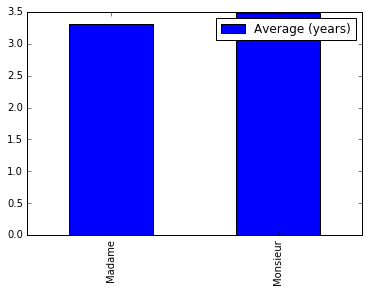

In [34]:
fBcData = bcData[bcData.Civilité == "Madame"]
mBcData = bcData[bcData.Civilité == "Monsieur"]

bcResult = pd.DataFrame({'Average (years)':[0.0, 0.0]},
                        index = ["Madame","Monsieur"])

bcResult.loc['Madame'] = CalcBachelorSpan(fBcData)
bcResult.loc['Monsieur'] = CalcBachelorSpan(mBcData)

bcResult.plot(kind='bar')
bcResult

## Summary

It seems female students take a bit less time than male students to graduate from EPFL.

# Assignment 2

## Clean up

Now let's apply a similar approach on master students. This time we can start from raw data `fData` because it preserves master entries as well.

In [112]:
# extract data of master students from fData
msData = fData.copy()
msData = msData[msData.Études == "Informatique"]
msData.index = msData['No Sciper']
msData = msData[[("Master" in per) for per in msData['Semestre']]]
msData = msData.drop(["Orientation Bachelor", "Orientation Master", "Filière opt.", "Ecole Echange", "Type Echange", "Études", "No Sciper"],1)
msData.head()

,Civilité,Nom Prénom,Spécialisation,Mineur,Statut,Période,Semestre
No Sciper,,,,,,,
271331,Monsieur,Adams Marc Alain,,,Présent,2016-2017,Master semestre 1
273101,Monsieur,Adamsons Valdis,,,Présent,2016-2017,Master semestre 1
267543,Monsieur,Agapiou Stylianos,,,Présent,2016-2017,Master semestre 1
202293,Monsieur,Aiulfi Loris Sandro,,,Présent,2016-2017,Master semestre 1
228219,Monsieur,Alfonso Peterssen Alfonso,Foundations of Software,,Présent,2016-2017,Master semestre 1


The following array shows that `msData` includes all the semester entries we desire.

In [113]:
msData.Semestre.unique()

array([' Master semestre 1', ' Master semestre 2', ' Master semestre 3',
       ' Projet Master automne', ' Projet Master printemps'], dtype=object)

First we kick out students who __don't have both MA1 and MA2 entries__.

In [114]:
msScipers = msData.index.unique()
for sciper in msScipers:
    Finished = (True in ["2" in student for student in msData.loc[sciper].Semestre])
    Started = (True in ["1" in student for student in msData.loc[sciper].Semestre])
    
    if not Finished or not Started:
        msData = msData.drop(sciper,0)

Then we kick out students who __have a Mineur or a Specialisation, but don't have a MA3 entry__.

In [115]:
msScipers = msData.index.unique()
for sciper in msScipers:
    Finished = (True in ["3" in student for student in msData.loc[sciper].Semestre])
    Mineur = (True in [msData.loc[sciper].Mineur.any() != ''])
    Specialisation = (True in [msData.loc[sciper].Spécialisation.any() != ''])
    
    if (Mineur or Specialisation) and not Finished:
        msData = msData.drop(sciper,0)

In [116]:
msData.tail()

,Civilité,Nom Prénom,Spécialisation,Mineur,Statut,Période,Semestre
No Sciper,,,,,,,
167447,Monsieur,Taggiasco Matthieu,,,Présent,2007-2008,Master semestre 2
178057,Madame,Tomar Anmol,,,Présent,2007-2008,Master semestre 2
155097,Monsieur,Wei Zhe,,,Présent,2007-2008,Master semestre 2
169839,Monsieur,Zalakain Ilazki,,,Présent,2007-2008,Master semestre 2
166264,Monsieur,Zufferey Damien,Foundations of Software,,Présent,2007-2008,Master semestre 2


## Calculation

In [117]:
# average time to graduate for all master students
def CalcMasterSpan(msData):
    
    msScipers = msData.index.unique()
    
    time = 0
    
    for sciper in msScipers:
        sem_count = msData.loc[sciper].shape[0]
        time = time + sem_count * 0.5
    return time/len(msScipers)

In [118]:
CalcMasterSpan(msData)

1.7018716577540107

It takes, in average, 1.70 Years to finish studies in Informatics at EPFL. 

## Studies on specialisation

In [119]:
# divide data
specData = msData.copy()
noSpecData = msData.copy()
msScipers = msData.index.unique()

for sciper in msScipers:
    Specialisation = (True in [msData.loc[sciper].Spécialisation.any() != ''])
    
    if Specialisation:
        noSpecData = noSpecData.drop(sciper,0)
    if not Specialisation:
        specData = specData.drop(sciper,0)

,Average (years)
With spec,1.951965
No spec,1.591522


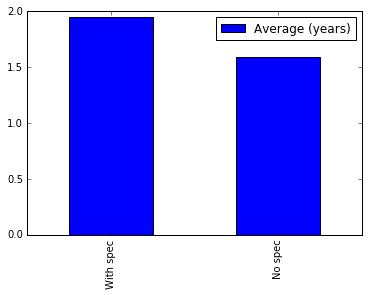

In [120]:
msResult = pd.DataFrame({'Average (years)':[0.0, 0.0]},
                  index = ["With spec", "No spec"])

msResult.loc['With spec'] = CalcMasterSpan(specData)
msResult.loc['No spec'] = CalcMasterSpan(noSpecData)

msResult.plot(kind='bar')
msResult

## Summary

It seems students who have a specialization take __significantly more time__ than those who don't to graduate from EPFL. However, the difference in between is __less than 0.5 years__ (which is the expected time to finish a specialization). It means that, generally speaking, students with a specialization would finish the original master program __quicker__ than their counterparts.

The result is logical because students who feel comfortable with their original master program would be more motivated to pick up a specialization.

# Assignment 3

## Bar chart: raw average

,Average (years)
Madame,1.707071
Monsieur,1.701079


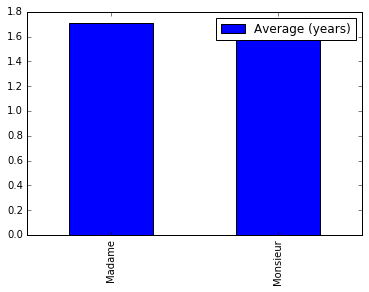

In [121]:
fMsData = msData[msData.Civilité == "Madame"]
mMsData = msData[msData.Civilité == "Monsieur"]

msGenderResult = pd.DataFrame({'Average (years)':[0.0,0.0]},
                              index = ["Madame", "Monsieur"])

msGenderResult.loc['Madame'] = CalcMasterSpan(fMsData)
msGenderResult.loc['Monsieur'] = CalcMasterSpan(mMsData)

msGenderResult.plot(kind='bar')
msGenderResult

## Scatter plot: trend over time

Now we need a new function to process the data, because we also need the year of entrance for each student to identify the trend over time.

In [139]:
def CalcMasterSpanAndEntranceYear(msData):
    
    msScipers = msData.index.unique()

    time = []
    entrTime = []
    gender = []
    
    for sciper in msScipers:
        par = msData.loc[sciper].tail(1).Période
        par = par.get_values()[0].split('-')
        moment = [int(s) for s in par[0].split() if s.isdigit()][0]
        entrTime.append(moment)
        
        sem_count = msData.loc[sciper].shape[0]
        time.append(sem_count * 0.5)
        
        if msData.loc[sciper].Civilité.any() == 'Madame':
            gender.append(1)
        else:
            gender.append(-1)
    
    msTimeResult = pd.DataFrame({'Time span': time}, 
                                {'Entrance Year': entrTime}, 
                                {'Gender': gender})
    
    #plt.scatter()
    
CalcMasterSpanAndEntranceYear(msData)

## Summary

Numerically, male and female students take roughly the same time to finish their master study.